# NHL predictions project - Data Interpretation

This is project for the subject Data Processing in Python - JEM207. That was created by Pavlína Křenková and Vojtěch Vaverka.

The code we wrote scrapes data from the website https://nhl.cz/. After the data is scraped, user of the code needs to fill in names of two teams into the variables team_1 and team_2. Once those two variables are set the code creates a Logistic regression that predicts which team is going to win. Druing our testing of the code we have reached accuracy above 50%. That means that the model is better than randomly guessing. Yet it should not be used to place bets.

First, we will prepare the data. Then, we will perform several analysis to familiarize even the non-hockey readers with the teams and their recent performence. Finally we estimate <span style="color:red">2 (?)</span> models to predict an outcome of the game. This prediction can be used for entertainment or casual betting; however, the authors do not take any responsibility if a user decides to do so.

## Preparation

### Importing the packages

* *pandas* - loading and working with the DataFrames
* *numpy* - working with matrices when building the logistic regression
* *matplotlib* - used for data visualization
* *sklearn* - used to build the logistic regression 
* *seaborn* - used for data visualization
* *statistics* - to compute the averages
* *ipywidgets* - for dropdown menus to choose which teams to analyze

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from statistics import mean
from ipywidgets import Dropdown

We load the necessary information about the teams, which we will later use for file loading and analysis

In [2]:
teams_info = pd.read_csv('teams_info/teams_info.csv')
#teams_info.head()

In [3]:
#We will be analysing the 5 most recent seasons
seasons_used = ['2017', '2018', '2019', '2020','2021'] #2017 is the 2017/2018 season, etc.

In [4]:
distinct_teams = teams_info['team'].tolist() #the list of all teams

In [5]:
#each team has its short name that was used to name the files that contain data
teams_dict = pd.Series(teams_info.team_short.values,index=teams_info.team).to_dict()
teams_dict

{'Anaheim Ducks': 'ANA',
 'Arizona Coyotes': 'ARI',
 'Boston Bruins': 'BOS',
 'Buffalo Sabres': 'BUF',
 'Calgary Flames': 'CGY',
 'Carolina Hurricanes': 'CAR',
 'Chicago Blackhawks': 'CHI',
 'Colorado Avalanche': 'COL',
 'Columbus Blue Jackets': 'CBJ',
 'Dallas Stars': 'DAL',
 'Detroit Red Wings': 'DET',
 'Edmonton Oilers': 'EDM',
 'Florida Panthers': 'FLA',
 'Los Angeles Kings': 'LAK',
 'Minnesota Wild': 'MIN',
 'Montreal Canadiens': 'MTL',
 'Nashville Predators': 'NSH',
 'New Jersey Devils': 'NJD',
 'New York Islanders': 'NYI',
 'New York Rangers': 'NYR',
 'Ottawa Senators': 'OTT',
 'Philadelphia Flyers': 'PHI',
 'Pittsburgh Penguins': 'PIT',
 'San Jose Sharks': 'SJS',
 'Seattle Kraken': 'SEA',
 'St. Louis Blues': 'STL',
 'Tampa Bay Lightning': 'TBL',
 'Toronto Maple Leafs': 'TOR',
 'Vancouver Canucks': 'VAN',
 'Vegas Golden Knights': 'VGK',
 'Washington Capitals': 'WSH',
 'Winnipeg Jets': 'WPG'}

## Choosing two teams and building the model

Below are 2 dropdown widgets. Please choose the two teams of your interest.

In [6]:
# ipywidgets do not show on github - run the notebook in order to see them
teams_info = pd.read_csv('teams_info/teams_info.csv')
option_list = teams_info['team'].tolist()
option_list.insert(0, '')
team_1_drop = ''
team_2_drop = ''
drop_down_team_1 = Dropdown(options=option_list,description='Choose the home team (Team 1):',disabled=False, 
                     display='flex',
                     flex_flow='column', align_items='stretch', style= {'description_width': 'initial'},
                     layout={'width': 'max-content'})
drop_down_team_2 = Dropdown(options=option_list,description='Choose the away team (Team 2):',disabled=False, 
                     display='flex',
                     flex_flow='column', align_items='stretch', style= {'description_width': 'initial'},
                     layout={'width': 'max-content'})
def dropdown_handler_team_1(choice):
    global team_1_drop
    print("Team 1:", choice.new)
    team_1_drop = choice.new
def dropdown_handler_team_2(choice):
    global team_2_drop
    print("Team 2:", choice.new)
    team_2_drop = choice.new
drop_down_team_1.observe(dropdown_handler_team_1, names='value')
drop_down_team_2.observe(dropdown_handler_team_2, names='value')
display(drop_down_team_1, drop_down_team_2)

Dropdown(description='Choose the home team (Team 1):', layout=Layout(width='max-content'), options=('', 'Anahe…

Dropdown(description='Choose the away team (Team 2):', layout=Layout(width='max-content'), options=('', 'Anahe…

Team 1: Los Angeles Kings
Team 2: New Jersey Devils


Now we check whether the choice was made.

In [59]:
if team_1_drop == "" or team_2_drop == "":  
    print("You have not chosen both teams yet, please return to previous cell and do so. \n"
    "If both teams are not chosen, the game between Boston Bruins and Tampa Bay Lightning will be predicted.")
    
    # A base arbitrary choice was made, so that all cells can be run at once.
    team_1 = "Boston Bruins"
    team_2 = "Tampa Bay Lightning"
    
    
elif team_1_drop == team_2_drop:
    
    print("You picked the same team twice, please return to previous cell and change at least one team.")
    # A base arbitrary choice was made, so that analysis can continue if user does not specify..
    # ..teams correctly
    team_1 = team_1_drop
    if team_1 == "Boston Bruins":
        team_2 = "Tampa Bay Lightning"
    else:
        team_2 = "Boston Bruins"
    
else:
    print("The outcome of the match", team_1_drop, "vs", team_2_drop, "will be predicted.")
    team_1 = team_1_drop
    team_2 = team_2_drop

The outcome of the match Los Angeles Kings vs New Jersey Devils will be predicted.


We obtain the short names of the teams and load the file with the processed data, that was created by *scraping.py* and *processing.py*

In [60]:
team_1_short = teams_dict[team_1]
team_2_short = teams_dict[team_2]

Variable names mean the following:
* *game_id* - unique game ID
* *TOI_result* - did Team of Interest (from now *TOI*, the team to which this dataframe belongs) win ( = 1) or loose ( = 0)
* *TOI_home* - did TOI play home ( = 1) or away ( = 0)
* *other_team* - who was the other team in the game
* *TOI_points_tot* - how many points did TOI gain in the last 20 games
* *TOI_goals_scored_tot* - how many goals did TOI score in the last 20 games
* *TOI_goals_rec_tot* - how many goals did TOI receive in the last 20 games
* *other_team_points_tot* - how many points did the other team gain in the last 20 games
* *other_team_goals_scored_tot* - how many goals did the other team score in the last 20 games
* *other_team_goals_rec_tot* - how many goals did the other team receive in the last 20 games

This <span style="color:red">word</span> is not black, it is red <span style="color:pink">:--)</span>.

### Model 1 - Logistic Regression

In [61]:
matches_team_1 = pd.read_csv(f'teams_final/{team_1_short}.csv')
matches_team_1.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,/zapas/2526387,0.0,1.0,Los Angeles Kings,Winnipeg Jets,32.0,62.0,50.0,38.0,67.0,56.0
1,/zapas/2526399,0.0,0.0,Los Angeles Kings,Arizona Coyotes,29.0,59.0,51.0,14.0,50.0,73.0
2,/zapas/2526412,1.0,1.0,Los Angeles Kings,Anaheim Ducks,29.0,58.0,50.0,27.0,54.0,57.0
3,/zapas/2526426,1.0,0.0,Los Angeles Kings,Detroit Red Wings,28.0,56.0,49.0,25.0,57.0,61.0
4,/zapas/2526435,1.0,0.0,Los Angeles Kings,Washington Capitals,28.0,57.0,48.0,30.0,53.0,61.0


We drop the unnecessary variables which will not be used for modelling.

In [62]:
#dropping unnecessary columns
matches_team_1 = matches_team_1.drop(columns=['game_id', 'TOI','other_team'])

In [63]:
matches_team_1

,TOI_result,TOI_home,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,0.0,1.0,32.0,62.0,50.0,38.0,67.0,56.0
1,0.0,0.0,29.0,59.0,51.0,14.0,50.0,73.0
2,1.0,1.0,29.0,58.0,50.0,27.0,54.0,57.0
3,1.0,0.0,28.0,56.0,49.0,25.0,57.0,61.0
4,1.0,0.0,28.0,57.0,48.0,30.0,53.0,61.0
...,...,...,...,...,...,...,...,...
346,1.0,0.0,27.0,53.0,66.0,16.0,50.0,76.0
347,1.0,1.0,28.0,52.0,65.0,18.0,64.0,78.0
348,1.0,1.0,30.0,53.0,62.0,14.0,48.0,76.0
349,1.0,0.0,33.0,57.0,59.0,26.0,55.0,63.0


#### This is the model we wish to estimate:

$$
\Large p = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 + \beta_7 x_7)}}
$$

Where:
* the dependent variable is TOI_result - win (1) or loose (0)

And the independent variables $x_1$ to $x_7$ are:
* *TOI_home*
* *TOI_points_tot*
* *TOI_goals_scored_tot*
* *TOI_goals_rec_tot*
* *other_team_points_tot*
* *other_team_goals_scored_tot*
* *other_team_goals_rec_tot*

#### Defining the independent and dependent variables

In [64]:
#independent
x = matches_team_1.iloc[:, 1:].values
#dependent - the result
y = matches_team_1.iloc[:, 0].values

#### Splitting into training and test set

In [65]:
matches_team_1.iloc[:, 1:] #this is how the dataset looks like now - all the independent variables

,TOI_home,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,1.0,32.0,62.0,50.0,38.0,67.0,56.0
1,0.0,29.0,59.0,51.0,14.0,50.0,73.0
2,1.0,29.0,58.0,50.0,27.0,54.0,57.0
3,0.0,28.0,56.0,49.0,25.0,57.0,61.0
4,0.0,28.0,57.0,48.0,30.0,53.0,61.0
...,...,...,...,...,...,...,...
346,0.0,27.0,53.0,66.0,16.0,50.0,76.0
347,1.0,28.0,52.0,65.0,18.0,64.0,78.0
348,1.0,30.0,53.0,62.0,14.0,48.0,76.0
349,0.0,33.0,57.0,59.0,26.0,55.0,63.0


In [66]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [67]:
X_test[:5]

array([[ 0., 28., 55., 46., 27., 56., 57.],
       [ 0., 32., 58., 56., 39., 71., 49.],
       [ 0., 31., 53., 56., 29., 55., 58.],
       [ 1., 34., 61., 53., 30., 60., 66.],
       [ 1., 23., 45., 56., 44., 78., 47.]])

In [68]:
# rescaling (standardizing) everything except the "home" dummy ... and then adding the dummy back
# since it makes the process faster and does not change predictions
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train[:,1:])
X_test_stand = scaler.transform(X_test[:,1:])
X_train_stand = np.insert(X_train_stand,0,X_train[:,0],axis=1)
X_test_stand = np.insert(X_test_stand,0,X_test[:,0],axis=1)

#### Getting the accuracy and confusion matrix

In [69]:
reg = LogisticRegression(max_iter = 400)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [70]:
#how well does the model perform?
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[15  6]
 [10  5]]


In [71]:
print("Accuracy :  \n", accuracy_score(y_test, y_pred))

Accuracy :  
 0.5555555555555556


#### Loading the data for the second team

In [72]:
matches_team_2 = pd.read_csv(f'teams_final/{team_2_short}.csv')
matches_team_2.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,/zapas/2526394,1.0,1.0,New Jersey Devils,Vancouver Canucks,33.0,65.0,65.0,32.0,56.0,56.0
1,/zapas/2526405,1.0,0.0,New Jersey Devils,Detroit Red Wings,33.0,62.0,65.0,27.0,58.0,59.0
2,/zapas/2526416,0.0,1.0,New Jersey Devils,Florida Panthers,32.0,60.0,65.0,21.0,56.0,68.0
3,/zapas/2526449,1.0,0.0,New Jersey Devils,Colorado Avalanche,32.0,60.0,63.0,29.0,67.0,67.0
4,/zapas/2526457,0.0,0.0,New Jersey Devils,Arizona Coyotes,32.0,59.0,62.0,17.0,48.0,67.0


#### the final prediction

In [73]:
matches_team_1_pre = pd.read_csv(f'teams_pre-processed/{team_1_short}_pre.csv')
matches_team_2_pre = pd.read_csv(f'teams_pre-processed/{team_2_short}_pre.csv')

#### We get the info about the last 20 games the teams played and input them into the estimated model

In [74]:
pred_team_1 = matches_team_1_pre[['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values

In [75]:
#je to v poradi points-goals scored-goals received
pred_team_1

array([35., 61., 60.])

In [76]:
pred_team_2 = matches_team_2_pre[['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values
pred_team_2

array([18., 60., 81.])

In [77]:
TOI_home = np.array([1]) #TOI - team_1 is the home team

In [78]:
values_to_fit = np.concatenate([TOI_home, pred_team_1, pred_team_2]).reshape(1, -1)

In [79]:
final_pred = reg.predict(values_to_fit)
final_pred

array([1.])

In [80]:
if final_pred[0] == 1:
    print('The team', team_1, "is predicted to win this game.")
elif final_pred[0] == 0:
    print('The team', team_2, "is predicted to win this game.")
else:
    print('An error occured along the way. Please try again.')

The team Los Angeles Kings is predicted to win this game.


#### Accuraccy of model 1 for every team

Now we calculate the accuracy of the logistic regression for every of the 32 teams, print out how many teams have lower accuracy than 50% (random chance), and we also compute the average accuracy over all teams.

In [81]:
#How accurate is the model for individual teams?
accuracies = []
accuracies_dict = {}
for one_team in distinct_teams:
    one_team_short = teams_dict[one_team]
    matches_one_team = pd.read_csv(f'teams_final/{one_team_short}.csv')
    matches_one_team = matches_one_team.drop(columns=['game_id', 'TOI','other_team'])
    x = matches_one_team.iloc[:, 1:].values
    y = matches_one_team.iloc[:, 0].values
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

    scaler = StandardScaler()
    X_train_stand = scaler.fit_transform(X_train[:,1:])
    X_test_stand = scaler.transform(X_test[:,1:])
    X_train_stand = np.insert(X_train_stand,0,X_train[:,0],axis=1)
    X_test_stand = np.insert(X_test_stand,0,X_test[:,0],axis=1)
    reg = LogisticRegression(max_iter = 400)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    accuracies.append(score)
    accuracies_dict[one_team] = score
    

print(accuracies_dict)
print(sum(acc < 0.5 for acc in accuracies), "teams have lower accuracy than 50%") #4 teams out of 32 have lower then 0.5 accuracy

{'Anaheim Ducks': 0.5277777777777778, 'Arizona Coyotes': 0.5142857142857142, 'Boston Bruins': 0.6944444444444444, 'Buffalo Sabres': 0.6285714285714286, 'Calgary Flames': 0.5555555555555556, 'Carolina Hurricanes': 0.6, 'Chicago Blackhawks': 0.5277777777777778, 'Colorado Avalanche': 0.5555555555555556, 'Columbus Blue Jackets': 0.4722222222222222, 'Dallas Stars': 0.5714285714285714, 'Detroit Red Wings': 0.6388888888888888, 'Edmonton Oilers': 0.6388888888888888, 'Florida Panthers': 0.5833333333333334, 'Los Angeles Kings': 0.5555555555555556, 'Minnesota Wild': 0.6, 'Montreal Canadiens': 0.5277777777777778, 'Nashville Predators': 0.5428571428571428, 'New Jersey Devils': 0.6285714285714286, 'New York Islanders': 0.5142857142857142, 'New York Rangers': 0.45714285714285713, 'Ottawa Senators': 0.75, 'Philadelphia Flyers': 0.5428571428571428, 'Pittsburgh Penguins': 0.42857142857142855, 'San Jose Sharks': 0.5, 'Seattle Kraken': 0.7142857142857143, 'St. Louis Blues': 0.5277777777777778, 'Tampa Bay 

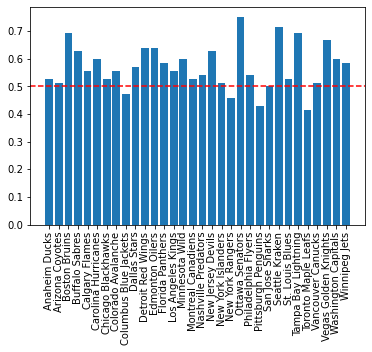

In [82]:
plt.bar(*zip(*accuracies_dict.items()))
plt.xticks(rotation='vertical')
plt.axhline(y= 0.5,color='red', linestyle ='dashed')
plt.show()

And how accurate is the model on average?

In [83]:
mean(accuracies) #the model is 57% accurate, on average

0.5710565476190476

<b>We can see that the model performs relatively good. Being 57% accurate on average, and only 4 teams out of 32 performing worse than a random chance. However, there might be a better solution. Let's try another model.</b>

<span style="color:red">odsud az po dalsi model vse presunout pred model 1, at v tom mame nejakej system</span>

### Calculating Home Advantage

In [32]:
#ja moc nevim jestli tenhle vypocet je dobre
all_matches = pd.read_csv('all_matches.csv')
sum_wins_home = sum(all_matches["goals_home"] > all_matches["goals_away"])
sum_wins_away = sum(all_matches["goals_home"] < all_matches["goals_away"])
 
home_winrate = sum_wins_home/(sum_wins_home+sum_wins_away)
home_winrate

0.5413507925568574

### calculating and visualising home advantage for all teams for all seasons together

In [33]:
home_advantages = {}
for one_team in distinct_teams:
    one_team_short = teams_dict[one_team]
    matches_one_team = pd.read_csv(f'teams_final/{one_team_short}.csv')
    home_ad = (sum((matches_one_team['TOI_home'] == 1) & (matches_one_team['TOI_result'] == 1)))/sum(matches_one_team['TOI_home'] == 1)
    home_advantages[one_team] = home_ad
    
home_advantages

#add points total, so that we can see if it corresponds

{'Anaheim Ducks': 0.4508670520231214,
 'Arizona Coyotes': 0.42528735632183906,
 'Boston Bruins': 0.6704545454545454,
 'Buffalo Sabres': 0.42134831460674155,
 'Calgary Flames': 0.5375722543352601,
 'Carolina Hurricanes': 0.6149425287356322,
 'Chicago Blackhawks': 0.42857142857142855,
 'Colorado Avalanche': 0.6514285714285715,
 'Columbus Blue Jackets': 0.5284090909090909,
 'Dallas Stars': 0.5795454545454546,
 'Detroit Red Wings': 0.39664804469273746,
 'Edmonton Oilers': 0.5375722543352601,
 'Florida Panthers': 0.6440677966101694,
 'Los Angeles Kings': 0.4797687861271676,
 'Minnesota Wild': 0.6193181818181818,
 'Montreal Canadiens': 0.43258426966292135,
 'Nashville Predators': 0.6022727272727273,
 'New Jersey Devils': 0.41954022988505746,
 'New York Islanders': 0.550561797752809,
 'New York Rangers': 0.5202312138728323,
 'Ottawa Senators': 0.44,
 'Philadelphia Flyers': 0.49714285714285716,
 'Pittsburgh Penguins': 0.6460674157303371,
 'San Jose Sharks': 0.5172413793103449,
 'Seattle Kraken

### calculating and visualising home advantage for individual seasons

In [34]:
home_advantage = pd.DataFrame(seasons_used, columns=['year'])
ha = []
for season in seasons_used:
    ha_one_season = sum(all_matches.loc[all_matches['season'] == int(season)]["home_wins"])/len(all_matches.loc[all_matches['season'] == int(season)]["home_wins"])
    ha.append(round(ha_one_season*100,3))
home_advantage["win_home_percentage"] = ha
home_advantage

,year,win_home_percentage
0,2017,56.334
1,2018,53.659
2,2019,53.327
3,2020,53.341
4,2021,53.659


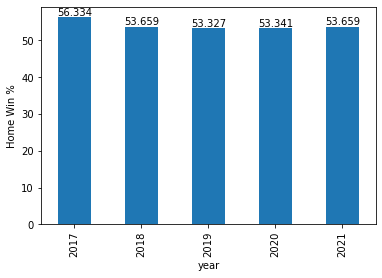

In [35]:
ha = home_advantage.plot(x = 'year', legend=False, kind = "bar")
plt.ylabel("Home Win %")
ha.bar_label(ha.containers[0], labels=home_advantage['win_home_percentage'])
plt.show()

### calculating home advantage for all teams and all seasons

In [36]:
sum(all_matches["home_wins"])/len(all_matches["home_wins"])

0.5413507925568574

### calculating and visualising home advantage for one specific team and all seasons

### After picking 2 teams both their final_dfs are found, saved and displayed

In [37]:
matches_team_1s = pd.read_csv(f'teams_final/{team_1_short}.csv')
matches_between_them = matches_team_1s.merge(matches_team_2, left_on='game_id', right_on='game_id',suffixes=('', '2'))
matches_between_them.drop(columns=['TOI_result2', 'TOI_home2','TOI2','other_team2','TOI_points_tot2','TOI_goals_scored_tot2','TOI_goals_rec_tot2'], inplace=True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
matches_between_them.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot,other_team_points_tot2,other_team_goals_scored_tot2,other_team_goals_rec_tot2
0,/zapas/2526431,1.0,1.0,Boston Bruins,Tampa Bay Lightning,30.0,56.0,59.0,42.0,70.0,47.0,30.0,56.0,59.0
1,/zapas/2527156,1.0,0.0,Boston Bruins,Tampa Bay Lightning,38.0,72.0,59.0,37.0,81.0,70.0,38.0,72.0,59.0
2,/zapas/2527244,1.0,1.0,Boston Bruins,Tampa Bay Lightning,34.0,64.0,61.0,34.0,72.0,68.0,34.0,64.0,61.0
3,/zapas/2527287,0.0,0.0,Boston Bruins,Tampa Bay Lightning,36.0,70.0,59.0,34.0,72.0,69.0,36.0,70.0,59.0
4,/zapas/2647632,0.0,0.0,Boston Bruins,Tampa Bay Lightning,30.0,45.0,48.0,38.0,82.0,65.0,30.0,45.0,48.0


In [38]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)

In [39]:
matches_between_them_ids = matches_between_them['game_id']
matches_between_them_ids

0     /zapas/2526431
1     /zapas/2527156
2     /zapas/2527244
3     /zapas/2527287
4     /zapas/2647632
           ...      
11    /zapas/2807430
12    /zapas/2897351
13    /zapas/2897606
14    /zapas/2898005
15    /zapas/2898120
Name: game_id, Length: 16, dtype: object

### Graphs

#### We create data frames for graphs and we ad variable match_ordr that displays the order of matches of a given team

In [40]:
matches_team_1_graphs = pd.read_csv(f'teams_pre-processed/{team_1_short}_pre.csv')
matches_team_2_graphs = pd.read_csv(f'teams_pre-processed/{team_2_short}_pre.csv')
matches_team_1_graphs['match_ordr'] = range(1, len(matches_team_1_graphs) + 1)
matches_team_2_graphs['match_ordr'] = range(1, len(matches_team_2_graphs) + 1)
matches_team_2_graphs.head()

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
0,/zapas/2526068,Tampa Bay Lightning,Florida Panthers,5,3,0,3.0,...,5.0,3.0,1.0,Florida Panthers,Tampa Bay Lightning,2017,1
1,/zapas/2526073,Florida Panthers,Tampa Bay Lightning,5,4,0,3.0,...,4.0,5.0,0.0,Florida Panthers,Tampa Bay Lightning,2017,2
2,/zapas/2526090,Tampa Bay Lightning,Washington Capitals,4,3,1,2.0,...,4.0,3.0,1.0,Washington Capitals,Tampa Bay Lightning,2017,3
3,/zapas/2526105,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,5.0,4.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2017,4
4,/zapas/2526122,Tampa Bay Lightning,St. Louis Blues,2,1,0,3.0,...,2.0,1.0,1.0,St. Louis Blues,Tampa Bay Lightning,2017,5


### Merge both teams into one dataframe and create a graph of scored goals

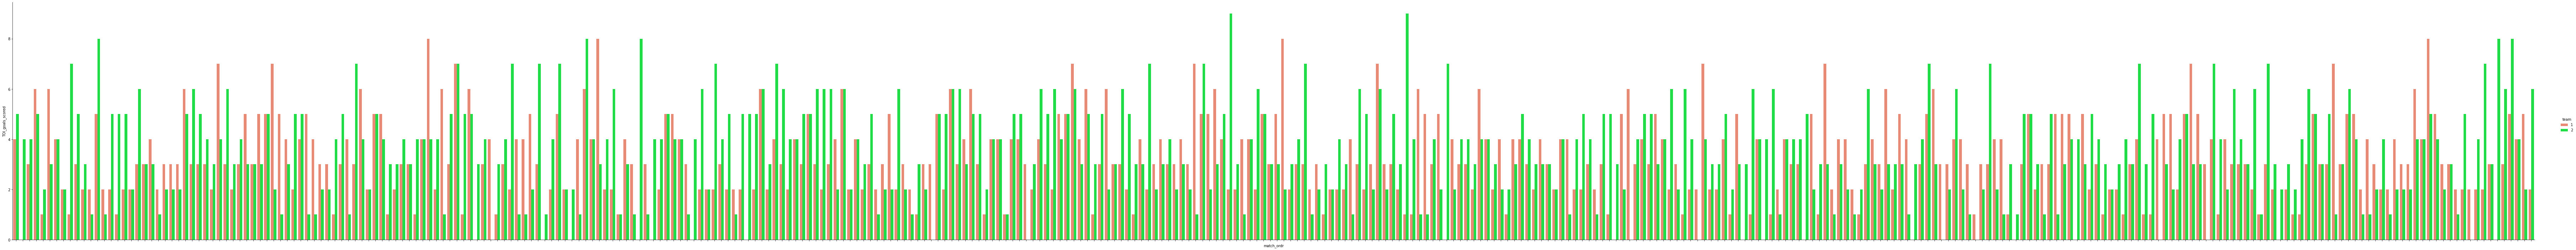

In [41]:
graphs = pd.concat([matches_team_1_graphs, matches_team_2_graphs], axis=0, ignore_index=False)
graphs['team'] = (len(matches_team_1_graphs)*(1,) + len(matches_team_2_graphs)*(2,))
graph_1 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='team', kind='bar', data=graphs, height=10, aspect=10, palette=["#FA7F63", "#00FC35"])
graph_1.set(xticklabels=[])
plt.show()

#### Too many matches we need to limit the data to last 30 matches

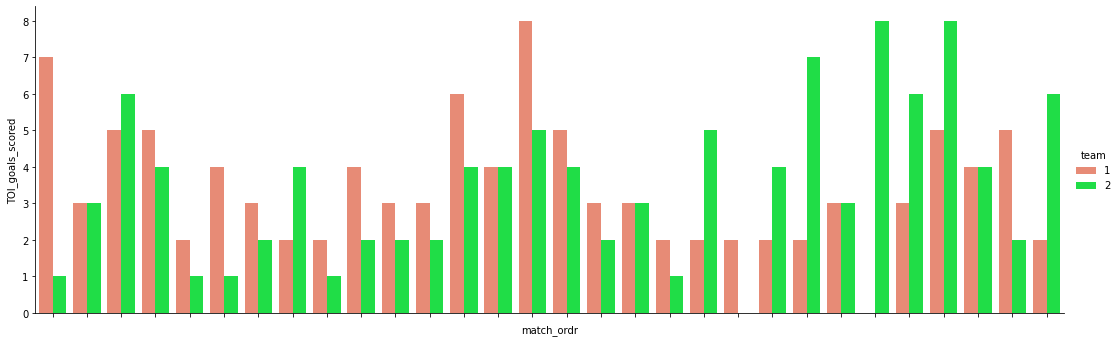

In [42]:
matches_team_1_graphs_30 = matches_team_1_graphs.tail(30)
matches_team_2_graphs_30 = matches_team_2_graphs.tail(30)
graphs_30_matches = pd.concat([matches_team_1_graphs_30, matches_team_2_graphs_30], axis=0, ignore_index=False)
graphs_30_matches['team'] = (len(matches_team_1_graphs_30)*(1,) + len(matches_team_2_graphs_30)*(2,))
graphs_30_matches
graph_2 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='team', kind='bar', data=graphs_30_matches, height=5, aspect=3, palette=["#FA7F63", "#00FC35"])
graph_2.set(xticklabels=[])
plt.show()

### Recived Goals

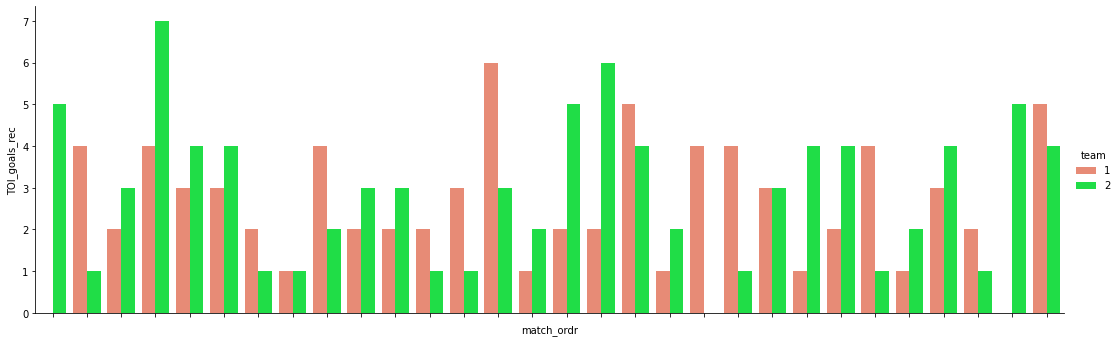

In [43]:
graph_3 = sns.catplot(x='match_ordr', y='TOI_goals_rec', hue='team', kind='bar', data=graphs_30_matches, height=5, aspect=3, palette=["#FA7F63", "#00FC35"])
graph_3.set(xticklabels=[])
plt.show()

### How teams did in last 30 matches

<function matplotlib.pyplot.show(close=None, block=None)>

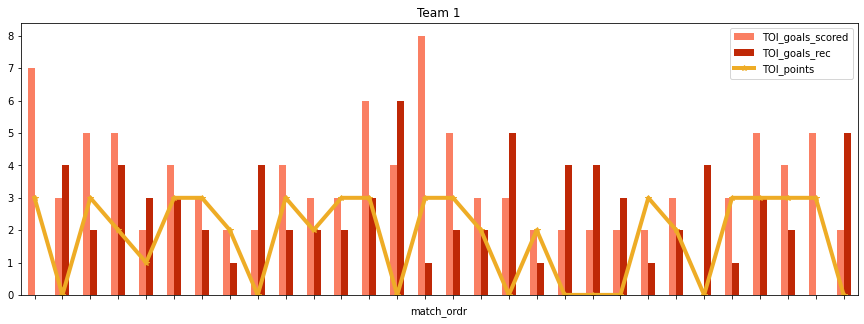

In [44]:
ax = matches_team_1_graphs_30[['TOI_goals_scored','TOI_goals_rec','match_ordr']].plot(
    x='match_ordr',kind='bar',figsize=(15, 5),color=["#FA7F63", "#BF2806"],title='Team 1')
matches_team_1_graphs_30[['TOI_points','match_ordr']].plot(x='match_ordr',  linestyle='-', marker='*',figsize=(15, 5),use_index=False,
                                                   color=["#EEAC26"], lw=4, ax=ax)
ax.set(xticklabels=[])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

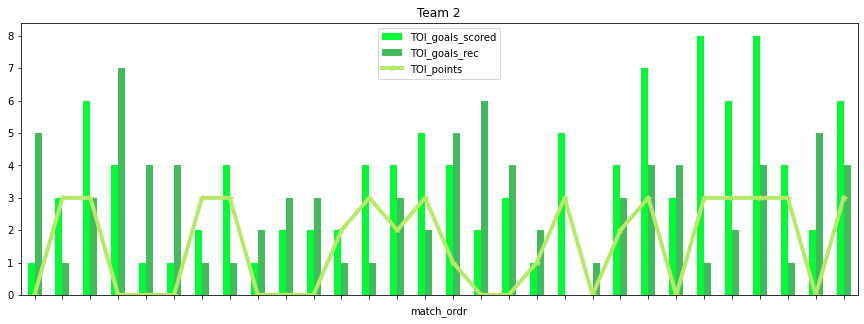

In [45]:
ax = matches_team_2_graphs_30[['TOI_goals_scored','TOI_goals_rec','match_ordr']].plot(
    x='match_ordr',kind='bar',figsize=(15, 5),color=["#00FC35", "#42BB5C"],title='Team 2')
matches_team_2_graphs_30[['TOI_points','match_ordr']].plot(x='match_ordr',  linestyle='-', marker='*',figsize=(15, 5),use_index=False,
                                                   color=["#B6E968"], lw=4, ax=ax)
ax.set(xticklabels=[])
plt.show

### Comparison of important variables for our model

<function matplotlib.pyplot.show(close=None, block=None)>

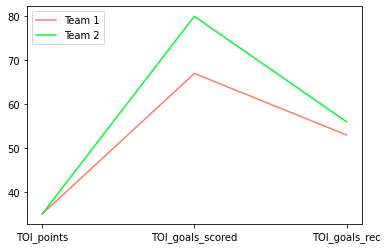

In [46]:
x_coordinates = ['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']
X_axis = np.arange(len(x_coordinates))
plt.plot(x_coordinates, pred_team_1,'#FA7F63',label="Team 1") 
plt.plot(x_coordinates, pred_team_2,'#00FC35',label="Team 2") 
plt.legend(loc="upper left")
plt.show

### 2nd model based on matches between 2 teams

In [47]:
#TOI = team 1 and should be home team to reflect home team advantage
second_model_mathes_filtered= matches_team_1_pre[matches_team_1_pre.other_team == team_2].copy()
second_model_mathes_filtered['match_ordr'] = range(1, len(second_model_mathes_filtered) + 1)
second_model_mathes_filtered

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
22,/zapas/2526431,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,...,3.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,1
69,/zapas/2527156,Tampa Bay Lightning,Boston Bruins,0,3,0,0.0,...,3.0,0.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,2
75,/zapas/2527244,Boston Bruins,Tampa Bay Lightning,4,2,0,3.0,...,4.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,3
78,/zapas/2527287,Tampa Bay Lightning,Boston Bruins,4,0,0,3.0,...,0.0,4.0,0.0,Tampa Bay Lightning,Boston Bruins,2017,4
109,/zapas/2647632,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,...,2.0,3.0,0.0,Tampa Bay Lightning,Boston Bruins,2018,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,/zapas/2807430,Boston Bruins,Tampa Bay Lightning,3,5,0,0.0,...,3.0,5.0,0.0,Tampa Bay Lightning,Boston Bruins,2019,12
310,/zapas/2897351,Boston Bruins,Tampa Bay Lightning,2,3,1,1.0,...,2.0,3.0,0.0,Tampa Bay Lightning,Boston Bruins,2021,13
320,/zapas/2897606,Tampa Bay Lightning,Boston Bruins,2,5,0,0.0,...,5.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2021,14
353,/zapas/2898005,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,...,3.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2021,15


### 2nd model here we predict winner based on wins and loses in duels between teams

In [48]:
model_2_data = sum(second_model_mathes_filtered.TOI_result)/len(second_model_mathes_filtered.TOI_result)
if model_2_data >= 0.5:
  print(team_1,"will win the match")
elif model_2_data < 0.5:
  print(team_2,"will win the match")
else:
  print("our model can not predict the winner as we do not have data  of", team_1,"facing ",team_2)

Boston Bruins will win the match


###  Another version of 2nd model here we predict winner based on points in duels between teams

In [49]:
model_2_data_b = sum(second_model_mathes_filtered.TOI_points)/(len(second_model_mathes_filtered.TOI_result)*3)
if model_2_data_b >= 0.5:
      print(team_1,"will win the match")
elif model_2_data_b < 0.5:
      print(team_2,"will win the match")
else:
      print("our model can not predict the winner as we do not have data  of", team_1,"faceing ",team_2)

Boston Bruins will win the match


### Accuracy


In [50]:
second_model_mathes_filtered_accuracy = second_model_mathes_filtered.iloc[:-1 , :] #we prepare a data set without the last match

In [51]:
second_model_mathes_filtered_result = second_model_mathes_filtered.tail(1) #the result of last match we are checking against

### Another try at accuracy

In [52]:
wins_before_this_match = []
points_before_this_match = []
matches_before_this_match = []
for x in second_model_mathes_filtered['match_ordr']:
    wins_before_this_match.append(second_model_mathes_filtered[(second_model_mathes_filtered['match_ordr'] < x)]['TOI_result'].sum())
    points_before_this_match.append(second_model_mathes_filtered[(second_model_mathes_filtered['match_ordr'] < x)]['TOI_points'].sum())
    matches_before_this_match.append(second_model_mathes_filtered[(second_model_mathes_filtered['match_ordr'] < x)]['TOI_points'].count())

second_model_mathes_filtered['wins_before_this_match'] = wins_before_this_match
second_model_mathes_filtered['points_before_this_match'] = points_before_this_match
second_model_mathes_filtered['matches_before_this_match'] = matches_before_this_match
second_model_mathes_filtered

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,other_team,TOI,season,match_ordr,wins_before_this_match,points_before_this_match,matches_before_this_match
22,/zapas/2526431,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2017,1,0.0,0.0,0
69,/zapas/2527156,Tampa Bay Lightning,Boston Bruins,0,3,0,0.0,...,Tampa Bay Lightning,Boston Bruins,2017,2,1.0,3.0,1
75,/zapas/2527244,Boston Bruins,Tampa Bay Lightning,4,2,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2017,3,2.0,6.0,2
78,/zapas/2527287,Tampa Bay Lightning,Boston Bruins,4,0,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2017,4,3.0,9.0,3
109,/zapas/2647632,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2018,5,3.0,9.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,/zapas/2807430,Boston Bruins,Tampa Bay Lightning,3,5,0,0.0,...,Tampa Bay Lightning,Boston Bruins,2019,12,5.0,16.0,11
310,/zapas/2897351,Boston Bruins,Tampa Bay Lightning,2,3,1,1.0,...,Tampa Bay Lightning,Boston Bruins,2021,13,5.0,16.0,12
320,/zapas/2897606,Tampa Bay Lightning,Boston Bruins,2,5,0,0.0,...,Tampa Bay Lightning,Boston Bruins,2021,14,5.0,17.0,13
353,/zapas/2898005,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2021,15,6.0,20.0,14


In [53]:
def predictions_score(row):
    if row['wins_before_this_match'] >= row['matches_before_this_match']/2:
        val = 1
    elif row['wins_before_this_match'] < row['matches_before_this_match']/2:
        val = 0
    return val    
second_model_mathes_filtered['Prediction_score'] = second_model_mathes_filtered.apply(predictions_score, axis=1)
def predictions_points(row):
    if row['wins_before_this_match'] >= row['matches_before_this_match']/2:
        val = 1
    elif row['wins_before_this_match'] < row['matches_before_this_match']/2:
        val = 0
    return val    
second_model_mathes_filtered['Prediction_points'] = second_model_mathes_filtered.apply(predictions_points, axis=1)

In [54]:
def correctness_score(row):
    if row['TOI_result'] == row['Prediction_score']:
        val = 1
    elif row['TOI_result'] != row['Prediction_score']:
        val = 0
    return val
second_model_mathes_filtered['correct_score'] = second_model_mathes_filtered.apply(correctness_score, axis=1)

def correctness_points(row):
    if row['TOI_result'] == row['Prediction_points']:
        val = 1
    elif row['TOI_result'] != row['Prediction_points']:
        val = 0
    return val
second_model_mathes_filtered['correct_points'] = second_model_mathes_filtered.apply(correctness_points, axis=1)

In [55]:
second_model_mathes_filteredd = second_model_mathes_filtered.iloc[1:].copy() #Remove the first row as we can not use model on it, so the resoult is wrong

In [56]:
accuracy_score_model = round((sum(second_model_mathes_filteredd['correct_score'])/max((second_model_mathes_filteredd['matches_before_this_match']))*100),2)
if second_model_mathes_filteredd.shape[0] == 0:
    print('Can not determine accuracy of the modela as there was not enoug matches betwen',team_1, 'and', team_2)
else:
    print('Accuracy of model based on wins in previous duels is',accuracy_score_model,'%')

Accuracy of model based on wins in previous duels is 40.0 %


In [57]:
accuracy_points_model = round((sum(second_model_mathes_filteredd['correct_points'])/max((second_model_mathes_filteredd['matches_before_this_match']))*100),2)
if second_model_mathes_filteredd.shape[0] == 0:
    print('Can not determine accuracy of the modela as there was not enoug matches betwen',team_1, 'and', team_2)
else:
    print('Accuracy of model based on points gained in previous duels is',accuracy_points_model,'%')

Accuracy of model based on points gained in previous duels is 40.0 %


In [58]:
second_model_mathes_filteredd

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,wins_before_this_match,points_before_this_match,matches_before_this_match,Prediction_score,Prediction_points,correct_score,correct_points
69,/zapas/2527156,Tampa Bay Lightning,Boston Bruins,0,3,0,0.0,...,1.0,3.0,1,1,1,1,1
75,/zapas/2527244,Boston Bruins,Tampa Bay Lightning,4,2,0,3.0,...,2.0,6.0,2,1,1,1,1
78,/zapas/2527287,Tampa Bay Lightning,Boston Bruins,4,0,0,3.0,...,3.0,9.0,3,1,1,0,0
109,/zapas/2647632,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,...,3.0,9.0,4,1,1,0,0
145,/zapas/2648182,Boston Bruins,Tampa Bay Lightning,4,1,0,3.0,...,3.0,9.0,5,1,1,1,1
157,/zapas/2648370,Tampa Bay Lightning,Boston Bruins,5,4,0,3.0,...,4.0,12.0,6,1,1,0,0
163,/zapas/2648455,Boston Bruins,Tampa Bay Lightning,3,6,0,0.0,...,4.0,12.0,7,1,1,0,0
170,/zapas/2806474,Boston Bruins,Tampa Bay Lightning,3,4,1,1.0,...,4.0,12.0,8,1,1,0,0
196,/zapas/2806864,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,...,4.0,13.0,9,0,0,1,1
230,/zapas/2807395,Tampa Bay Lightning,Boston Bruins,1,2,0,0.0,...,4.0,13.0,10,0,0,0,0
